In [1]:
import numpy as np
import numba as nb
from tqdm.notebook import trange, tqdm
from numba import njit, prange
from numba.typed import List
from matplotlib import pyplot as plt
from matplotlib import patches as mpatches
from matplotlib import animation

In [2]:
a = np.zeros(10, dtype=np.uint64)
b = np.frombuffer(a, dtype=np.uint16).reshape(-1, 4)


In [3]:
assert b.flags['C_CONTIGUOUS'] == True


In [4]:
@njit
def index_sorted(buf: np.ndarray, x: np.uint16, y: np.uint16):
    k = (np.uint32(x) << 32)+(np.uint32(y) << 48)
    idx = np.searchsorted(buf[1:buf[0]+np.uint64(1)], k)+1
    mask32_64 = np.uint64(18446744069414584320)
    if buf[idx] & mask32_64 == k and buf[0]+1 > idx:
        return idx
    else:
        assert buf.shape[0] > buf[0]+1
        buf[0] += 1
        buf[idx+1:buf[0]+np.uint64(1)] = buf[idx:buf[0]]
        buf[idx] = k
        return idx


@njit
def purge_index(buf: np.ndarray, idx: np.int32):
    buf[idx:buf[0]] = buf[idx+1:buf[0]+np.uint64(1)]
    buf[buf[0]] = 0
    buf[0] -= 1


@njit
def update_sorted(buf: np.ndarray, x: np.uint16, y: np.uint16, dv: np.uint16, u: np.uint16):
    idx = index_sorted(buf, x, y)
    mask0_15 = np.uint64(65535)
    mask32_64 = np.uint64(18446744069414584320)
    buf[idx] = ((mask32_64 & buf[idx])
                + np.uint64(np.uint32(u) << 16)
                + (mask0_15 & np.uint64(dv+buf[idx])))
    if ((mask0_15 & buf[idx])) == 0:
        purge_index(buf, idx)


@njit
def set_sorted(buf: np.ndarray, x: np.uint16, y: np.uint16, v: np.uint16, u: np.uint16):
    idx = index_sorted(buf, x, y)
    if v == 0 or u == 0:
        purge_coord_sorted(buf, x, y)
        return
    buf[idx] = (np.uint64(v)
                + (np.uint32(u) << 16)
                + (np.uint32(x) << 32)
                + (np.uint32(y) << 48))


@njit
def purge_coord_sorted(buf: np.ndarray, x: np.uint16, y: np.uint16):
    k = (np.uint32(x) << 32)+(np.uint32(y) << 48)
    idx = np.searchsorted(buf[1:buf[0]+np.uint64(1)], k)+1
    mask32_64 = np.uint64(18446744069414584320)
    if (buf[idx] & mask32_64) == k:
        purge_index(buf, idx)


In [5]:
@njit
def update_cell(lattice: np.ndarray, x: np.uint16, y: np.uint16, ds: np.uint16, dz: np.uint16, dr: np.uint16, s_buf64: np.ndarray, z_buf64: np.ndarray):
    s, z, r = lattice[x, y]
    lattice[x, y,0] += ds
    lattice[x, y,1] += dz
    lattice[x, y,2] += dr
    X, Y, _ = lattice.shape
    neighbors_xy = np.array([[-1, 0], [1, 0], [0, -1], [0, 1], [0, 0]], dtype=np.int32)
    neighbors_xy[:, 0] = (neighbors_xy[:, 0]+x) % X
    neighbors_xy[:, 1] = (neighbors_xy[:, 1]+y) % Y
    nzs = np.uint16(0)
    nss = np.uint16(0)
    if ds != 0:
        for nx, ny in neighbors_xy:
            nz = lattice[nx, ny, 1]
            nzs += nz
            if nz != 0 and (nx!=x or ny!=y):  # neighbor have Z!=0
                update_sorted(z_buf64, nx, ny, np.uint16(ds), nz)
        set_sorted(s_buf64, x, y, nzs, np.uint16(s+ds))
    elif s!=0:
        update_sorted(s_buf64, x, y, np.uint16(dz), np.uint16(s+ds))    
    if dz != 0:
        for nx, ny in neighbors_xy:
            ns = lattice[nx, ny, 0]
            nss += ns
            if ns != 0 and (nx!=x or ny!=y):  # neighbor have S!=0
                update_sorted(s_buf64, nx, ny, np.uint16(dz), ns)
        set_sorted(z_buf64, x, y, nss, np.uint16(z+dz))
    elif z!=0:
        update_sorted(z_buf64, x, y, np.uint16(ds), np.uint16(z+dz))


In [6]:
@njit
def weighted_sample(p: np.ndarray):
    cumulative_distribution = np.cumsum(p)
    a = np.float32(cumulative_distribution[-1])
    return np.searchsorted(cumulative_distribution, np.random.uniform(0, a), side="right")


@njit
def get_modified_xy(lattice: np.ndarray, initiator_xy: np.ndarray, target_idx: np.uint16):
    x, y = initiator_xy
    X, Y, _ = lattice.shape
    neighbors_xy = np.array(
        [[-1, 0], [1, 0], [0, -1], [0, 1], [0, 0]], dtype=np.int32)
    neighbors_xy[:, 0] = (neighbors_xy[:, 0]+x) % X
    neighbors_xy[:, 1] = (neighbors_xy[:, 1]+y) % Y
    p = np.empty(neighbors_xy.shape[0], dtype=np.uint16)
    for i in range(neighbors_xy.shape[0]):
        nx, ny = neighbors_xy[i]
        p[i] = lattice[nx, ny, target_idx]
    if np.sum(p) == 0:
        shape = lattice[x-np.uint(2):x+np.uint(3),
                        y-np.uint(2):y+np.uint(3), 0].shape
        ll = np.empty(shape)
        print(x, y)
        ll[:, :] = lattice[x-np.uint(2):x+np.uint(3),
                           y-np.uint(2):y+np.uint(3), 0]    
        ll[:, :] -= lattice[x-np.uint(2):x+np.uint(3),
                            y-np.uint(2):y+np.uint(3), 1]
        print(ll, target_idx)
        assert False
    return neighbors_xy[weighted_sample(p)]


In [7]:
@njit
def uszr_sample(lattice: np.ndarray, s_buf16: np.ndarray, z_buf16: np.ndarray, alpha: float = 0.25):
    # neighbor count, self count, x,y
    b = 1
    k = b*alpha
    K = k*s_buf16[0, 0]
    B = b*z_buf16[0, 0]
    dt = np.random.exponential(1/(K+B))
    if np.random.rand() < K/(K+B):
        buf16 = s_buf16[1:s_buf16[0, 0]+np.uint16(1)]
        dszr = (np.uint16(0), np.uint16(-1), np.uint16(1))
        idx = 1
    else:
        buf16 = z_buf16[1:z_buf16[0, 0]+np.uint16(1)]
        idx = 0
        dszr = (np.uint16(-1), np.uint16(1), np.uint16(0))

    initiator_idx = weighted_sample(buf16[:, 1])
    initiator_xy = buf16[initiator_idx, 2:]
    x, y = get_modified_xy(lattice, initiator_xy, np.uint16(idx))

    return x, y, dszr, dt

@njit
def szr_sample(lattice: np.ndarray, s_buf16: np.ndarray, z_buf16: np.ndarray, alpha: float = 0.25):
    # neighbor count, self count, x,y
    b = 1
    k = b*alpha
    ls=s_buf16[0,0]+np.uint(1)
    lz=z_buf16[0,0]+np.uint(1)
    ps=np.sum(s_buf16[1:ls,0]*s_buf16[1:ls,1])
    pz=np.sum(z_buf16[1:lz,0]*z_buf16[1:lz,1])
    if ps!=pz:
        print(s_buf16[1:ls])
        print(z_buf16[1:lz])
        print(ps,pz)
        print(lattice[:,:,0])
        print(lattice[:,:,1])
        assert False
    K = k*ps
    B = b*pz
    dt = np.random.exponential(1/(K+B))
    if np.random.rand() < K/(K+B):
        buf16 = s_buf16[1:s_buf16[0, 0]+np.uint16(1)]
        dszr = (np.uint16(0), np.uint16(-1), np.uint16(1))
        idx = 1
    else:
        buf16 = z_buf16[1:z_buf16[0, 0]+np.uint16(1)]
        idx = 0
        dszr = (np.uint16(-1), np.uint16(1), np.uint16(0))

    initiator_idx = weighted_sample(buf16[:, 1]*buf16[:, 0])
    initiator_xy = buf16[initiator_idx, 2:]
    x, y = get_modified_xy(lattice, initiator_xy, np.uint16(idx))

    return x, y, dszr, dt


In [8]:
def run_lattice(lattice: np.ndarray, s_buf64: np.ndarray, z_buf64: np.ndarray, alpha: float, uszr: bool = True):
    s_buf16 = np.frombuffer(s_buf64, dtype=np.uint16).reshape(-1, 4)
    z_buf16 = np.frombuffer(z_buf64, dtype=np.uint16).reshape(-1, 4)
    ms = 0
    mz = 0
    T = 0.
    if uszr:
        sample = uszr_sample
    else:
        sample = szr_sample
    for i in trange(np.sum(lattice[:, :, :2])*2):
        if s_buf64[0] > ms:
            ms = s_buf64[0]
        if z_buf64[0] > mz:
            mz = z_buf64[0]
        if s_buf64[0] != 0 and z_buf64[0] != 0:
            x, y, (ds, dz, dr), dt = sample(lattice, s_buf16, z_buf16, alpha)
            T += dt
            update_cell(lattice, x, y, ds, dz, dr, s_buf64, z_buf64)
        else:
            print('max S, Z buf sizes:', ms, mz)
            print('Time elapsed:', T)
            assert z_buf64[0] == 0 and s_buf64[0] == 0
            break


In [9]:
@njit
def nb_seed(seed):
    np.random.seed(seed)

In [10]:
np.set_printoptions(threshold=np.inf,linewidth=100000)

In [11]:
def exec(L:int,seed:int,alpha:float=0.25,uszr:bool=True,thickness:int=1):
    nb_seed(seed)
    lattice = np.zeros((L, L, 3), dtype=np.uint16)
    lattice[:, :, 0] = thickness
    s_buf64 = np.zeros((L*10*thickness), dtype=np.uint64)
    z_buf64 = np.zeros((L*10*thickness), dtype=np.uint64)

    update_cell(lattice, np.uint16(0), np.uint16(0), np.uint16(-thickness), np.uint16(thickness), np.uint16(0), s_buf64, z_buf64)
    run_lattice(lattice,s_buf64,z_buf64,alpha,uszr)
    return lattice

In [12]:
def plt_lattice(lattice: np.ndarray):
    patches = [mpatches.Patch(color=(1, 0, 0), label="Z"),
               mpatches.Patch(color=(0, 1, 0), label="S"),
               mpatches.Patch(color=(0, 0, 1), label="R")
               ]
    lattice_fig = np.empty_like(lattice, dtype=np.float32)
    th = np.max(lattice)
    lattice_fig[:, :, 0] = lattice[:, :, 1]
    lattice_fig[:, :, 1] = lattice[:, :, 0]
    lattice_fig[:, :, 2] = lattice[:, :, 2]
    plt.figure(figsize=(6, 6),dpi=150)
    plt.legend(handles=patches, bbox_to_anchor=(1, 1), loc=0, borderaxespad=0.,prop={'size': 10})
    plt.imshow(lattice_fig/th,interpolation='None')

    plt.draw()


In [13]:
lattice_szr=exec(2048,0,alpha=0.437,uszr=False,thickness=1)

  0%|          | 0/8388608 [00:00<?, ?it/s]

max S, Z buf sizes: 2007 1542
Time elapsed: 3562.0546064877967


In [14]:
lattice_uszr=exec(2048,0,alpha=0.253,uszr=True,thickness=1)

  0%|          | 0/8388608 [00:00<?, ?it/s]

max S, Z buf sizes: 1391 1019
Time elapsed: 7373.7979961050905


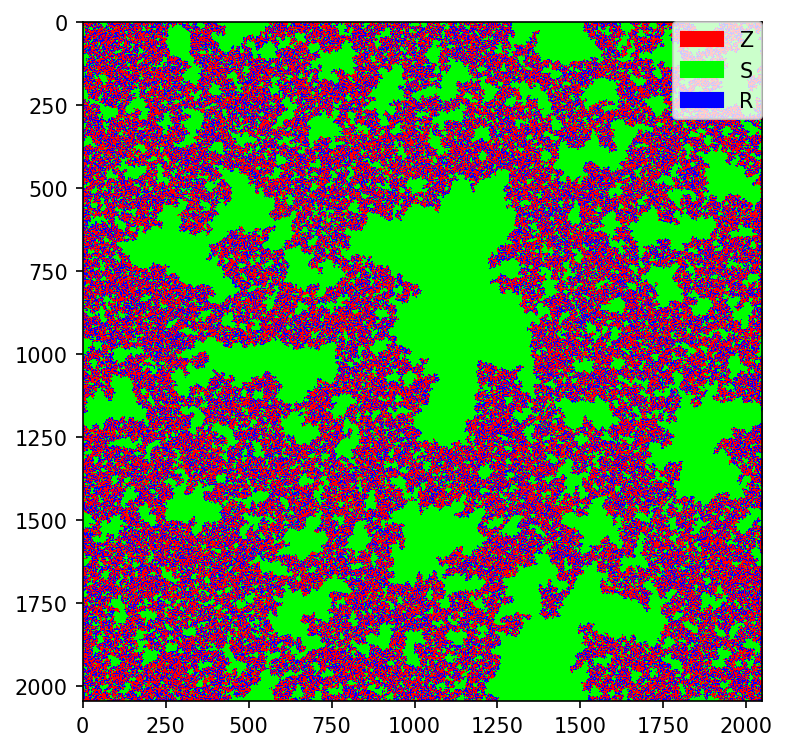

In [15]:
plt_lattice(lattice_szr)

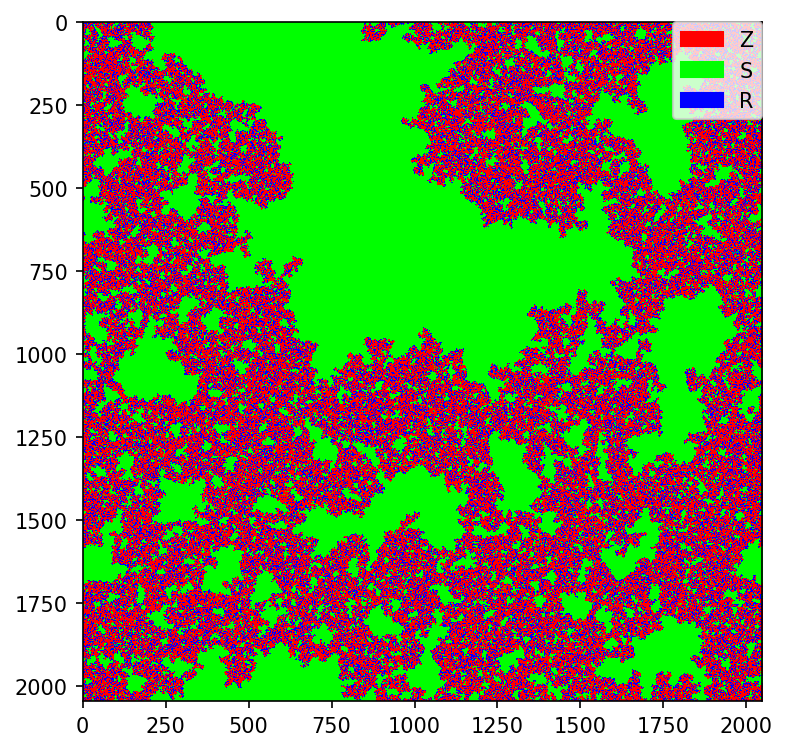

In [16]:
plt_lattice(lattice_uszr)

In [17]:
lattice_szr2=exec(1024,4,alpha=0.65,uszr=False,thickness=2)

  0%|          | 0/4194304 [00:00<?, ?it/s]

max S, Z buf sizes: 4011 2892
Time elapsed: 632.8608691570752


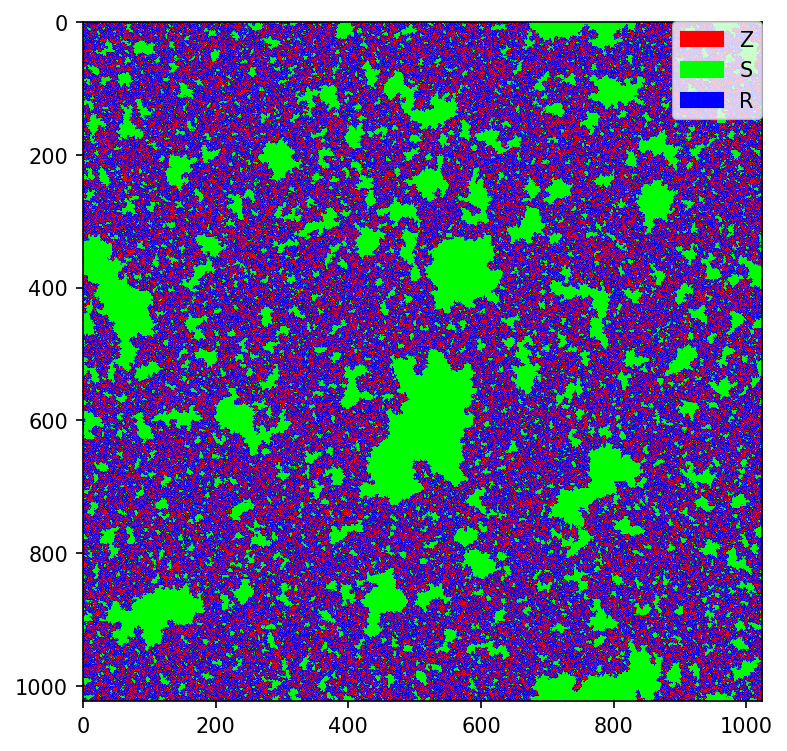

In [18]:
plt_lattice(lattice_szr2)

In [19]:
lattice_uszr2=exec(1024,0,alpha=0.32,uszr=True,thickness=2)

  0%|          | 0/4194304 [00:00<?, ?it/s]

max S, Z buf sizes: 1091 769
Time elapsed: 4476.06973044114


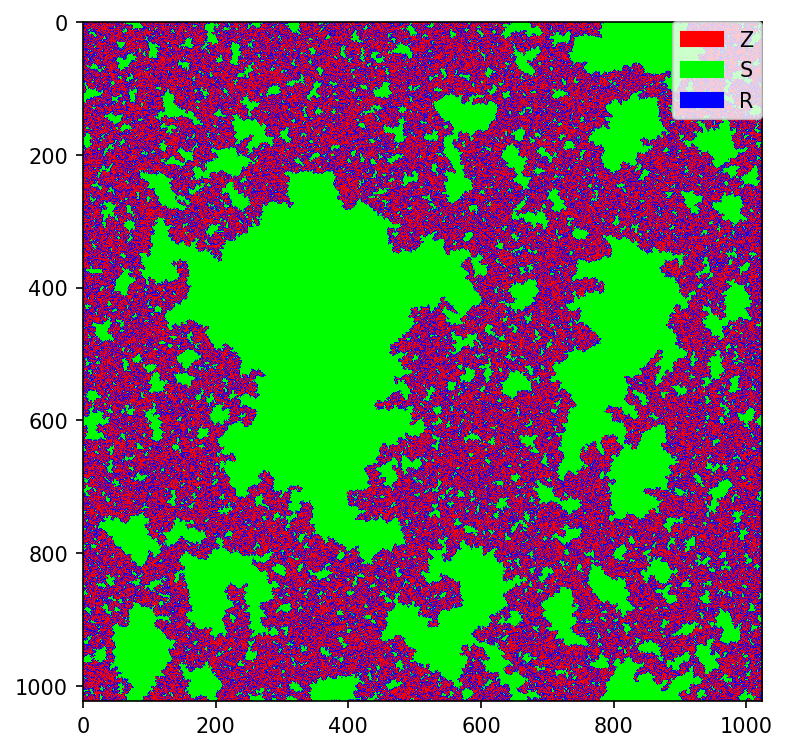

In [20]:
plt_lattice(lattice_uszr2)

In [21]:
lattice_szr3=exec(1024,0,alpha=0.75,uszr=False,thickness=3)

  0%|          | 0/6291456 [00:00<?, ?it/s]

max S, Z buf sizes: 4378 3046
Time elapsed: 370.47641385668754


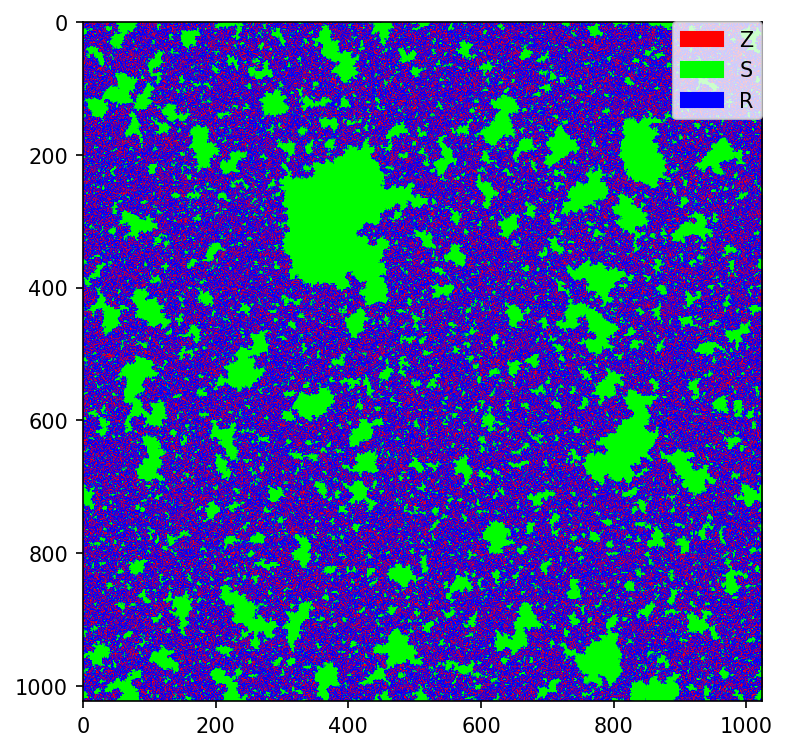

In [22]:
plt_lattice(lattice_szr3)

In [23]:
lattice_uszr3=exec(1024,1,alpha=0.347,uszr=True,thickness=3)

  0%|          | 0/6291456 [00:00<?, ?it/s]

max S, Z buf sizes: 1735 1236
Time elapsed: 4116.25186560902


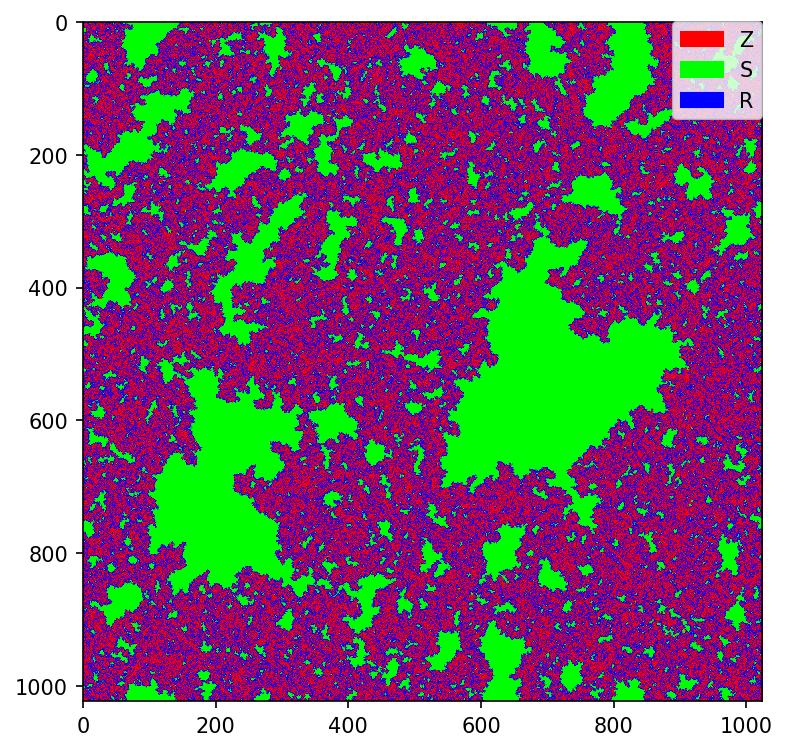

In [24]:
plt_lattice(lattice_uszr3)

In [25]:
lattice_uszr10=exec(512,1,alpha=0.41,uszr=True,thickness=10)

  0%|          | 0/5242880 [00:00<?, ?it/s]

max S, Z buf sizes: 1524 1301
Time elapsed: 3711.5594018293154


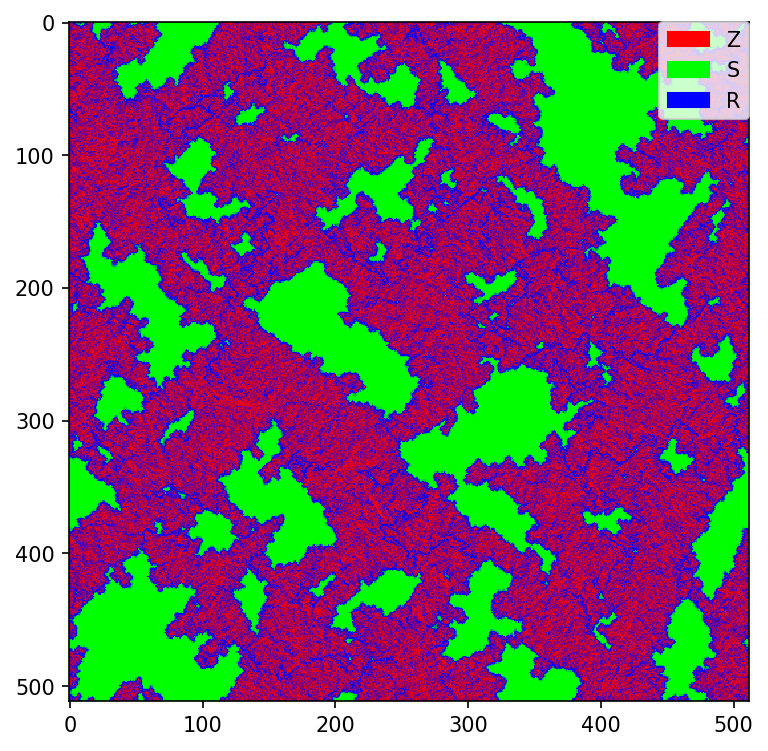

In [26]:
plt_lattice(lattice_uszr10)

In [27]:
lattice_uszr100=exec(256,1,alpha=0.45,uszr=True,thickness=100)

  0%|          | 0/13107200 [00:00<?, ?it/s]

max S, Z buf sizes: 503 476
Time elapsed: 23875.893190028066


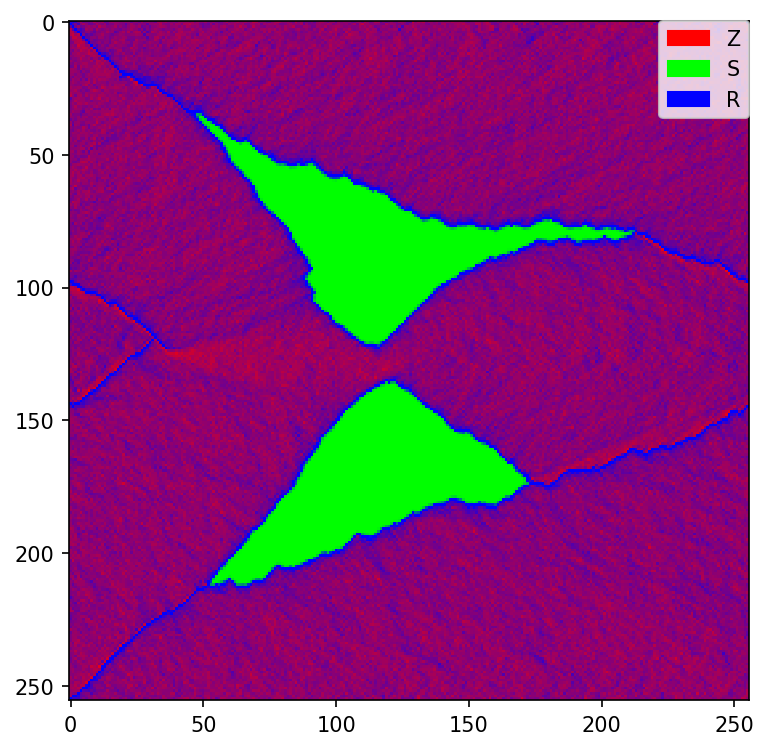

In [28]:
plt_lattice(lattice_uszr100)

In [29]:
def gen_image(L: int, seed: int, alpha: float = 0.25, uszr: bool = True, thickness: int = 1, frame_distance: int = 5):
    nb_seed(seed)
    lattice = np.zeros((L, L, 3), dtype=np.uint16)
    lattice[:, :, 0] = thickness
    s_buf64 = np.zeros((L*10*thickness), dtype=np.uint64)
    z_buf64 = np.zeros((L*10*thickness), dtype=np.uint64)
    s_buf16 = np.frombuffer(s_buf64, dtype=np.uint16).reshape(-1, 4)
    z_buf16 = np.frombuffer(z_buf64, dtype=np.uint16).reshape(-1, 4)
    update_cell(lattice, np.uint16(0), np.uint16(0), np.uint16(-thickness),
                np.uint16(thickness), np.uint16(0), s_buf64, z_buf64)
    lattice_fig = np.empty_like(lattice, dtype=np.float32)
    th = np.max(lattice)
    T = 0.
    T0 = 0
    if uszr:
        sample = uszr_sample
    else:
        sample = szr_sample

    for i in trange(np.sum(lattice[:, :, :2])*2):
        if T >= T0:
            T0+=frame_distance
            lattice_fig[:, :, 0] = lattice[:, :, 1]
            lattice_fig[:, :, 1] = lattice[:, :, 0]
            lattice_fig[:, :, 2] = lattice[:, :, 2]
            yield lattice_fig/th,T
        if s_buf64[0] != 0 and z_buf64[0] != 0:
            x, y, (ds, dz, dr), dt = sample(lattice, s_buf16, z_buf16, alpha)
            T += dt
            update_cell(lattice, x, y, ds, dz, dr, s_buf64, z_buf64)
        else:
            assert z_buf64[0] == 0 and s_buf64[0] == 0
            break


In [30]:
def updatefig(lattice_T):
    lattice,T=lattice_T
    global ann
    ann.set_text('T:{:.5f}'.format(T))
    im=plt.imshow(lattice)
    return im,

  0%|          | 0/13107200 [00:00<?, ?it/s]

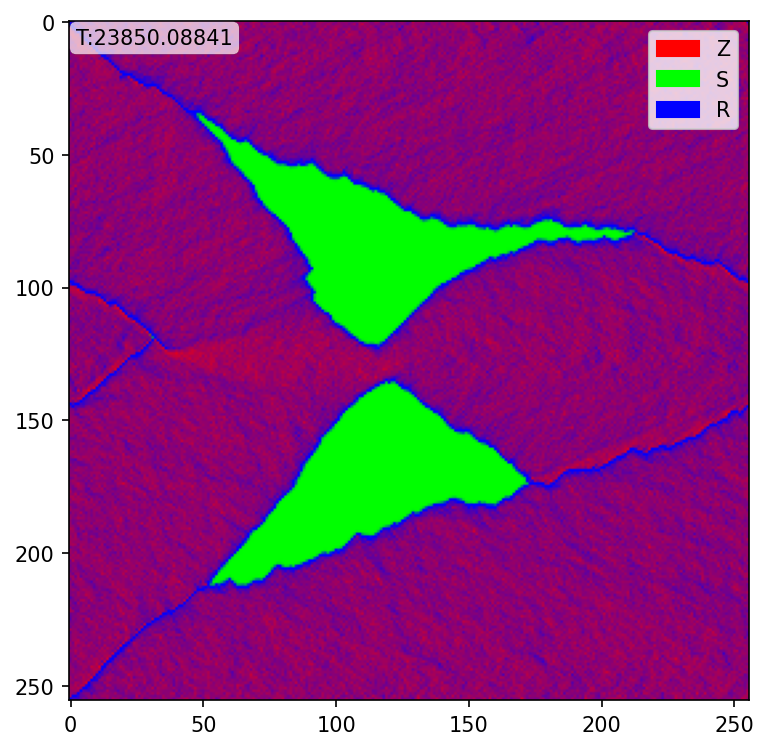

In [31]:
fig=plt.figure(figsize=(6,6),dpi=150)
ann=plt.annotate("T:0.00000",xy=(0.01, 0.966),xycoords='axes fraction',bbox=dict(boxstyle='round', facecolor='white', alpha=0.7,linewidth=0.1),)
patches = [mpatches.Patch(color=(1, 0, 0), label="Z"),
            mpatches.Patch(color=(0, 1, 0), label="S"),
            mpatches.Patch(color=(0, 0, 1), label="R")
            ]
plt.legend(handles=patches)
frames=gen_image(256,1,alpha=0.45,uszr=True,thickness=100,frame_distance=50)
ani = animation.FuncAnimation(fig, updatefig, blit=True, frames=frames, save_count=99999)
ani.save('Z:/256x100.mp4', fps=60, extra_args=['-vcodec', 'libx264'])

  0%|          | 0/5242880 [00:00<?, ?it/s]

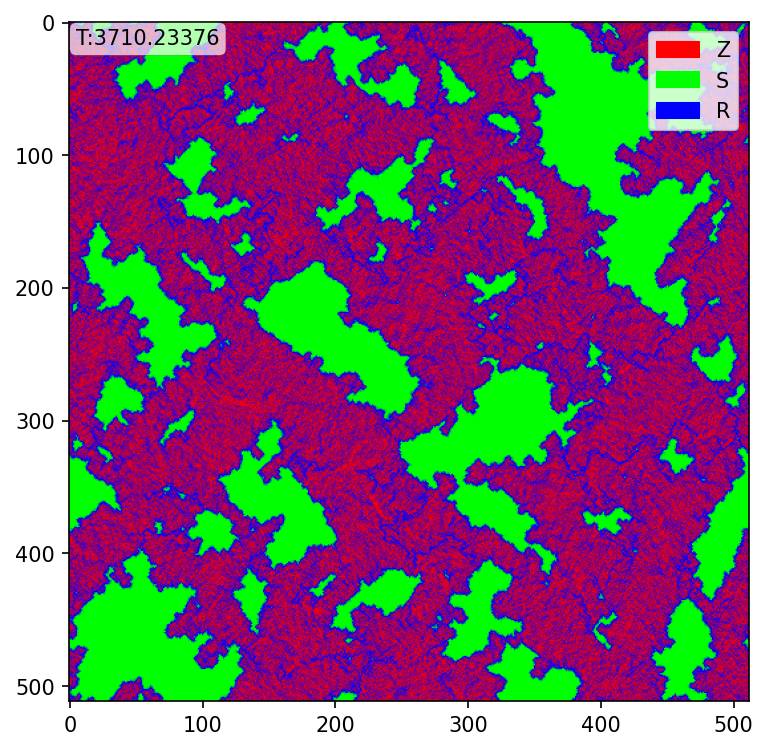

In [35]:
fig=plt.figure(figsize=(6,6),dpi=150)
ann=plt.annotate("T:0.00000",xy=(0.01, 0.966),xycoords='axes fraction',bbox=dict(boxstyle='round', facecolor='white', alpha=0.7,linewidth=0.1),)
patches = [mpatches.Patch(color=(1, 0, 0), label="Z"),
            mpatches.Patch(color=(0, 1, 0), label="S"),
            mpatches.Patch(color=(0, 0, 1), label="R")
            ]
plt.legend(handles=patches)
frames=gen_image(512,1,alpha=0.41,uszr=True,thickness=10,frame_distance=10)
ani = animation.FuncAnimation(fig, updatefig, blit=True, frames=frames, save_count=99999)
ani.save('Z:/512x10.mp4', fps=60, extra_args=['-vcodec', 'libx264'])